# **AMEX EDA**

# Introduction

American Express Company (called also Amex) is a multinational corporation with a sepcialisation in payment cards. It is present on the New York Stock Exchange (NYSE) with a ticker AXP. New York is also a city where they have the headquarter. They employ over 63k employees worldwide and hold about 23% payment card market in US.

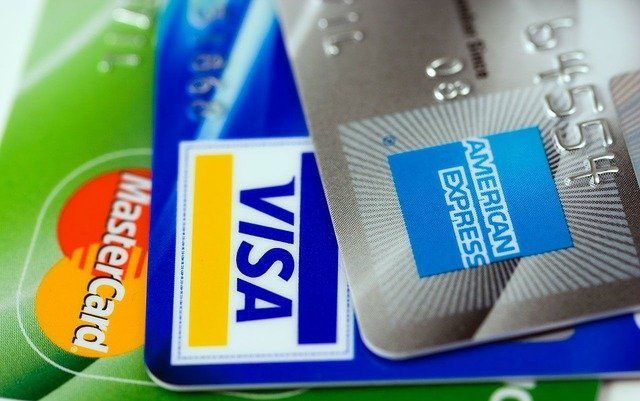

As for many banks the core of its operation is crediting, it's crucial to manage it efficiently. Especially banks want to lend money only to people who can pay the loan. That's why in this chalange we are asked to find out which customers are not able to do it. Not paying the money back is called `default`. This notebook explores the American Express (AMEX) churn prediction dataset.  

Here's a nice [McKinsely's article](https://www.mckinsey.com/industries/technology-media-and-telecommunications/our-insights/grow-fast-or-die-slow-focusing-on-customer-success-to-drive-growth) about the impact of churn on businesses.

Some other useful resources:
* [Predict Customer Churn in Python (Towards Data Science)](https://towardsdatascience.com/predict-customer-churn-in-python-e8cd6d3aaa7)
* [Churn Prediction- Commercial use of Data Science (Analytics Vidhya](https://www.analyticsvidhya.com/blog/2021/08/churn-prediction-commercial-use-of-data-science/)
* [Can You Predict Customer Churn ? (Youtube)](https://www.youtube.com/watch?v=ocMd2loRfWE)

In this competition the evaluation metric is referenced in [this notebook](https://www.kaggle.com/code/inversion/amex-competition-metric-python). It uses two submetrics where one is a normalized Gini coefficient, a good and clean explanation of this metrics can be found [here](https://theblog.github.io/post/gini-coefficient-intuitive-explanation/).

# Reading libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc  # Garbage collector

warnings.filterwarnings('ignore')

# Reading data

Because this dataset is huge and reading it directly from the .csv file consumes almost the entire memory we have to find a workaround. There are essentialy two options:
* Read data chunk by chunk
* Used a compressed dataset

In [2]:
TRAIN_DATA_PATH = "../input/amex-default-prediction/train_data.csv"

# Reading in chunks

In [3]:
chunksize = 13000
df_train_raw_chunks = pd.read_csv(TRAIN_DATA_PATH, chunksize=chunksize)

Everytime you run the cell below you'll get a new chunk.

In [4]:
df_train_raw_ch = df_train_raw_chunks.__next__()
df_train_raw_ch.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827


Now, we can do with this chunk all what we want. For example subsample a chunk only to data of a single customer.

In [5]:
sample_customer_id = np.random.choice(df_train_raw_ch['customer_ID'])
customer_data_ex = df_train_raw_ch[df_train_raw_ch["customer_ID"] == sample_customer_id]
customer_data_ex.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
7760,005e62244f20387f65299be88607d73b349f2267f080c5...,2017-03-09,0.775003,0.006028,0.023350,1.006725,0.004753,0.081072,0.001592,0.002123,...,NaN,NaN,NaN,0.001479,0.003712,0.006647,NaN,0.006274,0.004148,0.000921
7761,005e62244f20387f65299be88607d73b349f2267f080c5...,2017-04-20,0.774465,0.383720,0.049494,1.007912,0.003175,0.079010,0.009097,0.003963,...,NaN,NaN,NaN,0.006667,0.001866,0.000384,NaN,0.001744,0.009212,0.005081
7762,005e62244f20387f65299be88607d73b349f2267f080c5...,2017-05-10,0.771793,0.001773,0.041009,1.006812,0.006793,0.085722,0.008510,0.008770,...,NaN,NaN,NaN,0.005980,0.008506,0.005603,NaN,0.005564,0.003626,0.009069
7763,005e62244f20387f65299be88607d73b349f2267f080c5...,2017-06-21,0.776767,0.387970,0.032042,1.000268,0.008807,0.095404,0.002325,0.007177,...,NaN,NaN,NaN,0.006303,0.005796,0.002322,NaN,0.002066,0.001051,0.005920
7764,005e62244f20387f65299be88607d73b349f2267f080c5...,2017-07-28,0.770458,0.001576,0.014528,1.007365,0.007074,0.094990,0.007148,0.001521,...,NaN,NaN,NaN,0.009709,0.008930,0.001423,NaN,0.006689,0.001453,0.005700


As this method is somehow usefull for EDA it desn't allow you to explore the entire distribution of data and thus the second option is preffered. So let's clean the memory.

In [6]:
del df_train_raw_chunks, df_train_raw_ch, customer_data_ex, sample_customer_id
gc.collect()

42

# Reading a compressed dataset

There is an pre-processed, lightweight version of this dataset (train data already merged with labels): [AMEX-Feather-Dataset](https://www.kaggle.com/datasets/munumbutt/amexfeather) (thank you [Munum](https://www.kaggle.com/munumbutt)!). This dataset is available in Apache's feather format (more about it you can read [here](https://arrow.apache.org/docs/python/feather.html)). There is also a parquet version ([Amex Competition Data in Parquet Format](https://www.kaggle.com/datasets/odins0n/amex-parquet)). However, I'll stick to the feather format as it's more memory-efficient.

Before you can use it, you have to add it to your environment by clicking **"+ Add data"** button in the upper right corner of Kaggle's interface. 

In [7]:
train_raw = pd.read_feather('../input/amexfeather/train_data.ftr')

In [8]:
train_raw.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


# EDA

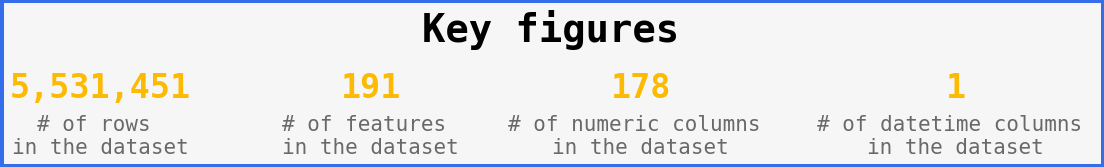

In [9]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

data = train_raw
df_dtypes = train_raw.dtypes.value_counts()

fig = plt.figure(figsize=(5,2),facecolor='white')

ax = fig.add_subplot(1,1,1)
font = 'monospace'
ax.text(1, 0.8, "Key figures",color='black',fontsize=28, fontweight='bold', fontfamily=font, ha='center')

ax.text(0, 0.4, "{:,d}".format(data.shape[0]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax.text(0, 0.001, "# of rows \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily=font,ha='center')

ax.text(0.6, 0.4, "{}".format(data.shape[1]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax.text(0.6, 0.001, "# of features \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily=font,ha='center')

ax.text(1.2, 0.4, "{}".format(len(data.select_dtypes(np.number).columns)), color='#fcba03', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax.text(1.2, 0.001, "# of numeric columns \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily=font, ha='center')

ax.text(1.9, 0.4,"{}".format(len(data.select_dtypes('datetime').columns)), color='#fcba03', fontsize=24, fontweight='bold', fontfamily=font, ha='center')
ax.text(1.9, 0.001,"# of datetime columns \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily=font,ha='center')

ax.set_yticklabels('')
ax.tick_params(axis='y',length=0)
ax.tick_params(axis='x',length=0)
ax.set_xticklabels('')

for direction in ['top','right','left','bottom']:
    ax.spines[direction].set_visible(False)

fig.subplots_adjust(top=0.9, bottom=0.2, left=0, hspace=1)

fig.patch.set_linewidth(5)
fig.patch.set_edgecolor('#346eeb')
fig.patch.set_facecolor('#f6f6f6')
ax.set_facecolor('#f6f6f6')
    
plt.show()

Let's check now what are the date ranges in our database.

In [10]:
print(f'Train dates range is from {train_raw["S_2"].min()} to {train_raw["S_2"].max()}.')

Train dates range is from 2017-03-01 00:00:00 to 2018-03-31 00:00:00.


We have slightly over one year of data.

## Missing data

Let's see now how many missing values do we have.

In [11]:
tmp = train_raw.isna().sum().div(len(train_raw)).mul(100).sort_values(ascending=False)

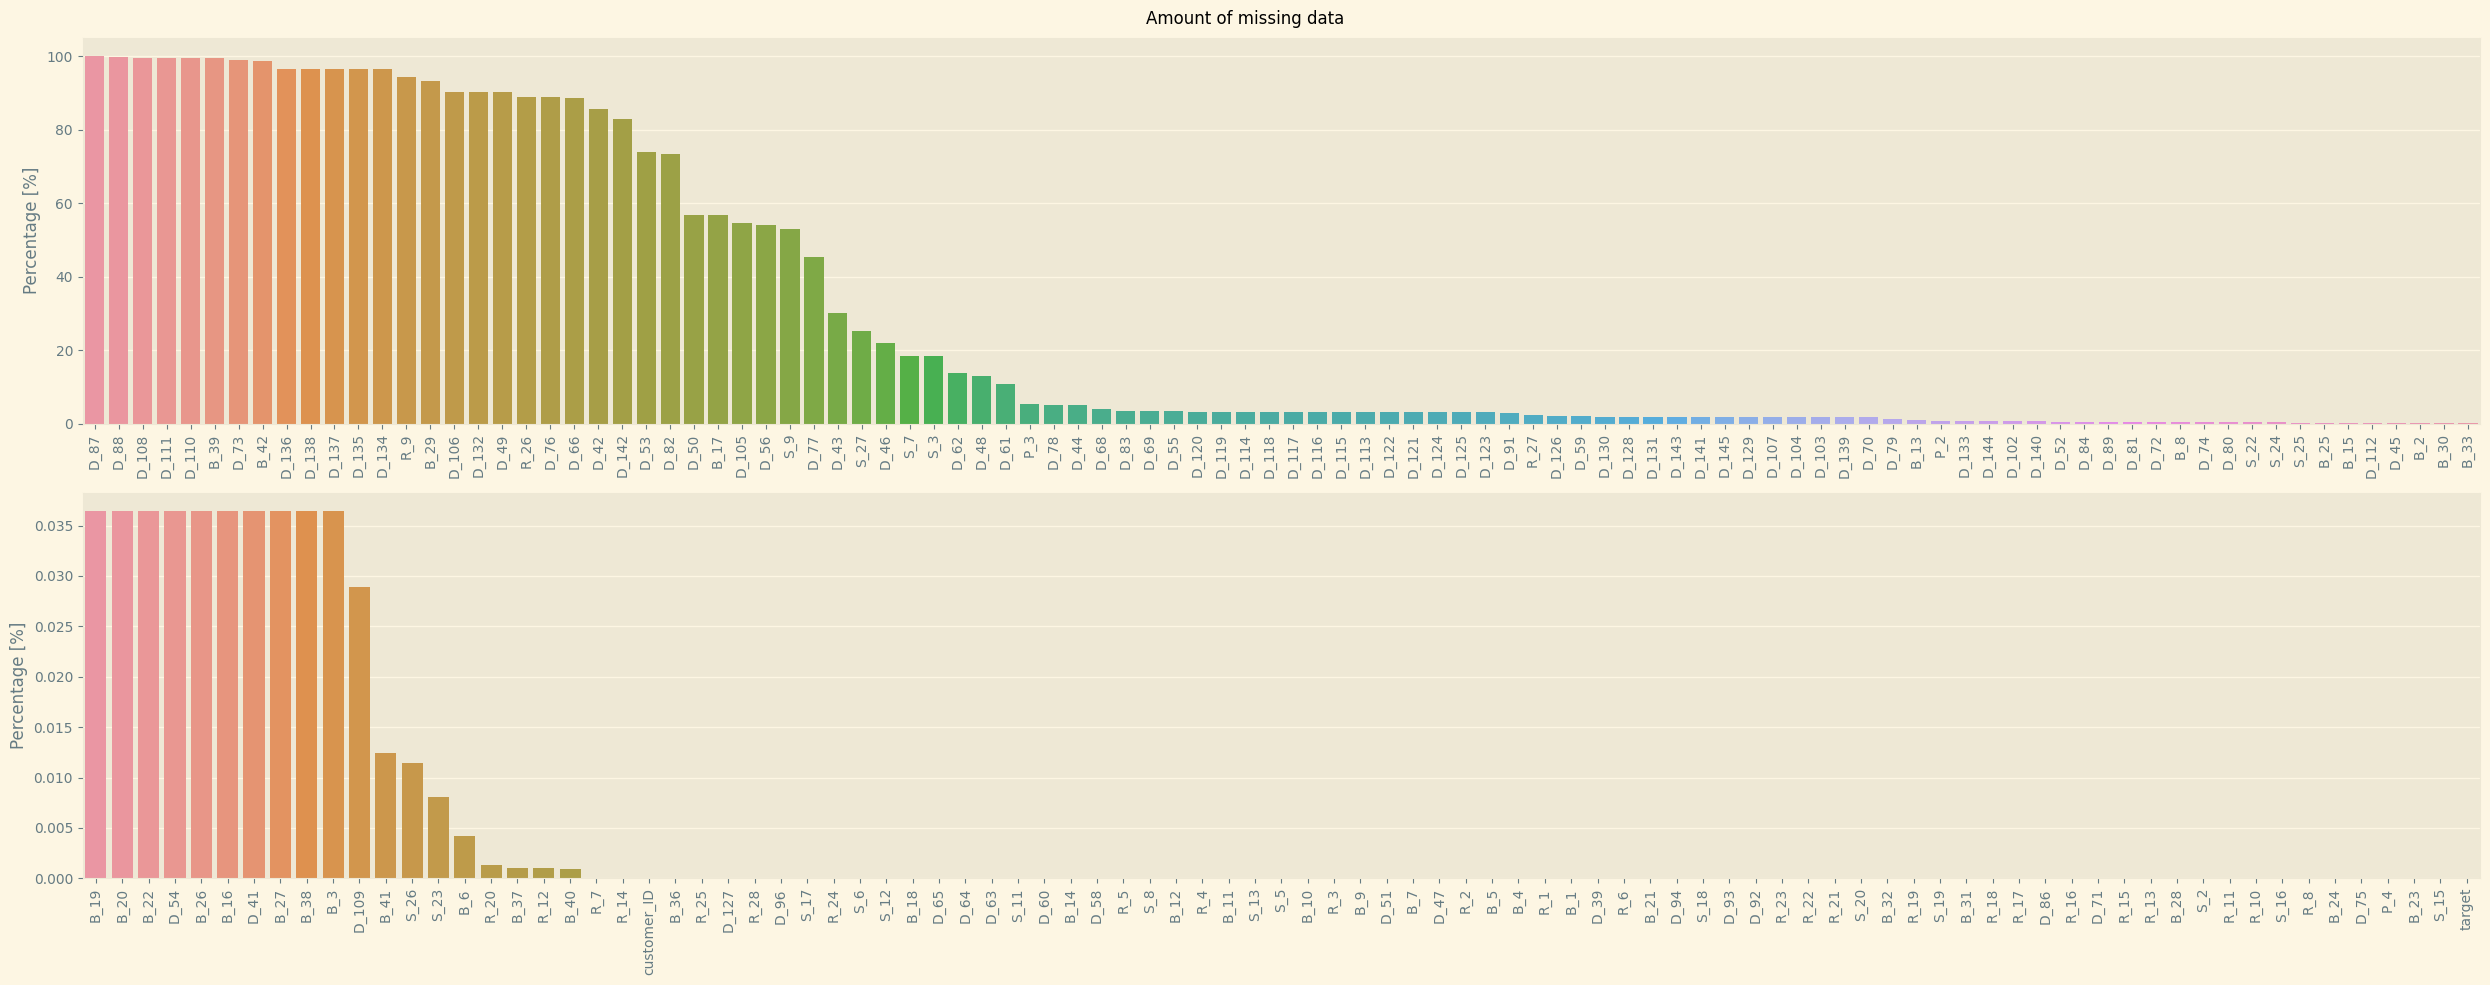

In [12]:
plt.style.use('Solarize_Light2')
fig, ax = plt.subplots(2,1, figsize=(25,10))
sns.barplot(x=tmp[:100].index, y=tmp[:100].values, ax=ax[0])
sns.barplot(x=tmp[100:].index, y=tmp[100:].values, ax=ax[1])
ax[0].set_ylabel("Percentage [%]"), ax[1].set_ylabel("Percentage [%]")
ax[0].tick_params(axis='x', rotation=90); ax[1].tick_params(axis='x', rotation=90)
plt.suptitle("Amount of missing data")
plt.tight_layout()
plt.show()

There is a significant number of features with a lot of missing data.

## Distribution of a target variable

Let's check now the distribution of the `target` variable.

In [13]:
tmp = train_raw['target'].value_counts().div(len(train_raw)).mul(100)

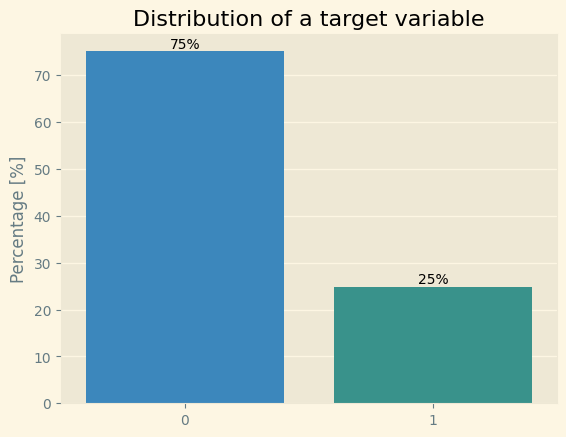

In [14]:
ax = sns.barplot(x=tmp.index, y=tmp.values)
ax.bar_label(ax.containers[0], fmt='%.f%%')
plt.title("Distribution of a target variable")
plt.ylabel("Percentage [%]")
plt.show()

It's clear that our dataset is unbalanced and this is a crucial point to keep in mind while modelling. 25% of customers had a default - it will be worth investigating these two groups separately to find some differences. First let's see how many unique customers do we have.

In [15]:
print(f'Number of unique customers: {train_raw["customer_ID"].nunique()}')

Number of unique customers: 458913


### Customers presence

We have about 459 000 unique customers.

In [16]:
cust_presence = train_raw.groupby(['customer_ID','target']).size().reset_index().rename(columns={0:'presence'})
cust_presence.head()

,customer_ID,target,presence
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0,13
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0,13
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0,13
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0,13
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0,13


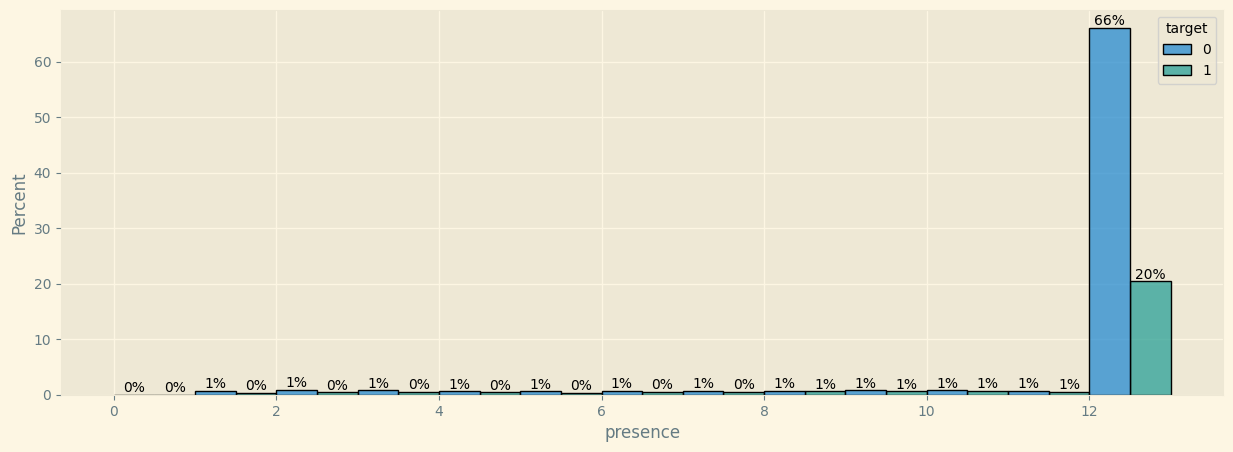

In [17]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.histplot(x='presence', data=cust_presence, hue='target', stat='percent', multiple="dodge", bins=np.arange(0,14), ax=ax)
ax.bar_label(ax.containers[0], fmt='%.f%%')
ax.bar_label(ax.containers[1], fmt='%.f%%')
plt.show()

The plot above shows how long are customer present in a dataset. It shows that 93% of them are visible for the entire full year. It's difficult from this graph to see how targets are distributed for the remaining customers, so let's zoom.

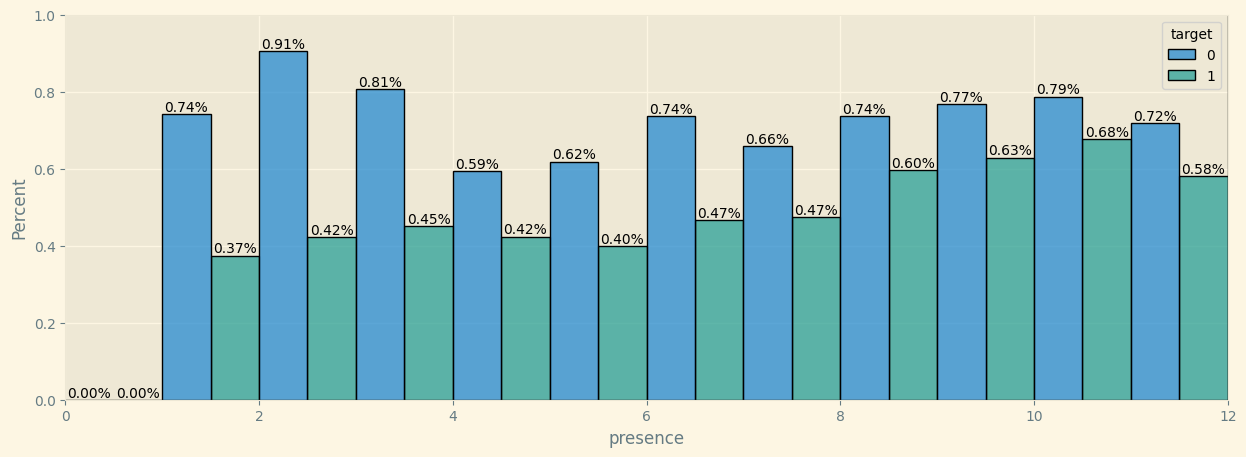

In [18]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.histplot(x='presence', data=cust_presence, hue='target', stat='percent', multiple="dodge", bins=np.arange(0,14), ax=ax)
ax.bar_label(ax.containers[0], fmt='%.2f%%')
ax.bar_label(ax.containers[1], fmt='%.2f%%')
ax.set_xlim(0,12)
ax.set_ylim(0,1)
plt.show()

Now it's clear that customers who are for a short time in a database are more prone to churn. We can add now this information as an additional feature if we want.
During a discussion [here](https://www.kaggle.com/competitions/amex-default-prediction/discussion/327597#1809185) there was a question who are customers with less than 13 observations. Let's investigate this.

In [19]:
short_customer_ids = list(cust_presence[cust_presence['presence']<13]['customer_ID'])
gc.collect()

55242

In [20]:
short_customers = train_raw[train_raw['customer_ID'].isin(short_customer_ids)][['customer_ID','S_2']]
short_customers['month'] = short_customers['S_2'].dt.month
short_customers['year'] = short_customers['S_2'].dt.year
short_customers.groupby(['year','month']).size()

year  month
2017  3         9596
      4        15522
      5        14272
      6        24350
      7        29568
      8        35065
      9        39421
      10       44258
      11       48234
      12       52876
2018  1        60221
      2        66747
      3        72879
dtype: int64

In [21]:
len(short_customers)

513009

If all "short" customers are only there due to late entry then all with the same presence number would be in the same month.

In [22]:
n=2
short_customer_ids_n = list(cust_presence[cust_presence['presence']<=n]['customer_ID'])

short_customers = train_raw[train_raw['customer_ID'].isin(short_customer_ids_n)][['customer_ID','S_2']]
short_customers['month'] = short_customers['S_2'].dt.month
short_customers['year'] = short_customers['S_2'].dt.year
print(f"Customers with presence equal to {n} observations.")
print(short_customers.groupby(['year','month']).size())

Customers with presence equal to 2 observations.
year  month
2017  3           27
      4           11
      5            4
      6            6
      7            2
      8            6
      9            1
      10           3
      11           2
      12           9
2018  1          271
      2         5756
      3        11218
dtype: int64


In [23]:
len(short_customers)

17316

Now, it's clear that short customers are also these who dropped from the observation period as well. Let's see now data for an exemplary customer from this subsample.

In [24]:
cust_2obs_03_2017 = list(short_customers.loc[(short_customers['year']==2017)&(short_customers['month']==3),'customer_ID'])

In [25]:
sample_customer = np.random.choice(cust_2obs_03_2017)
train_raw[train_raw["customer_ID"]==sample_customer].head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
1902136,57c34db3bc5708594ee5b6b14b79bfaa55a657d70894dc...,2017-03-28,NaN,0.009644,0.006172,0.817871,0.001419,NaN,0.003574,0.004143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1902137,57c34db3bc5708594ee5b6b14b79bfaa55a657d70894dc...,2018-03-29,0.797852,0.007381,0.006954,0.818359,0.007095,NaN,0.008774,0.008461,...,NaN,NaN,0.000958,0.002537,0.008278,NaN,0.008568,0.000044,0.005486,0


## Correlations

Before we dive in into distributions of the individual features let's check are there any highly correlated ones. Because it would take ags to calculate the entire correlation matrix I'll use an approximate method by using a sample of 550 000 observations (ca. 10% of the entire population).

In [26]:
correlations = train_raw.sample(550000).corr().abs()

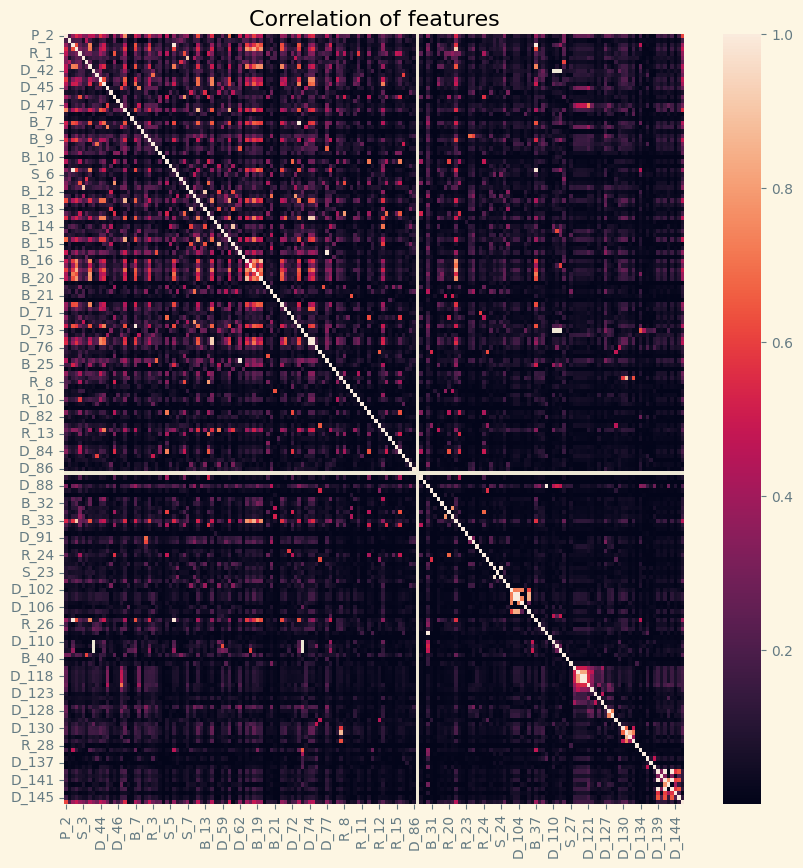

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(correlations, ax=ax)
ax.set_title("Correlation of features")
plt.show()

The graph above shows us that most of features is not correlated but there are visible lightcolor 'pixels' meaning we have some highly-correlated ones. In order to print them from the most correlated to the least we have to unstack the results.

In [28]:
unstacked = correlations.unstack()
unstacked.sort_values(ascending=False, kind="quicksort").drop_duplicates().head(25)

P_2    P_2      1.000000
D_62   D_77     0.999782
D_104  D_103    0.999749
D_139  D_143    0.999574
       D_141    0.998178
D_141  D_143    0.997786
B_11   B_1      0.995735
B_7    B_23     0.995084
D_119  D_118    0.994894
B_1    B_37     0.992870
B_11   B_37     0.988010
D_74   D_75     0.987715
S_24   S_22     0.978029
D_58   D_75     0.926519
D_74   D_58     0.923279
B_13   B_12     0.920835
B_2    B_33     0.913090
B_14   B_15     0.909448
S_3    S_7      0.904559
B_20   B_16     0.889042
D_132  D_131    0.874712
D_79   D_131    0.873625
D_55   D_48     0.862865
B_18   B_33     0.853721
B_2    B_18     0.849945
dtype: float64

Indeed we have a lot of highly correlated features. Worth keeping this in mind!

## Categorical features

We are given by the organizers a list of categorical features. Let's take a quick look at them.

In [29]:
categorical_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

train_raw[categorical_features].head()

,B_30,B_38,D_114,D_116,D_117,D_120,D_126,D_63,D_64,D_66,D_68
0,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
1,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
2,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
3,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0
4,0.0,2.0,1.0,0.0,4.0,0.0,1.0,CR,O,NaN,6.0


How many unique values are per categorical column?

In [30]:
train_raw[categorical_features].nunique()

B_30     3
B_38     7
D_114    2
D_116    2
D_117    7
D_120    2
D_126    3
D_63     6
D_64     5
D_66     2
D_68     7
dtype: int64

## Under construction
But if you like it so far, don't hesitate to upvote the notebook.

![](https://upload.wikimedia.org/wikipedia/en/4/4f/Under_construction.JPG)